Community Detection:

2. Community detection in networks.
 - synthetic data: random graphs, with random interconnecting edges + karate-klub, jazz/cora (as used here : https://github.com/esclear/louvain-leiden/tree/main/datasets)
 - get louvain and leiden codes to work from here (https://github.com/esclear/louvain-leiden/tree/main/)
 - compare algorithm with louvain, leiden and label propagation wrt accuracy score, ratio of within cluster edges / inter cluster edges and modularity -> Table 3.
 - For our algorithm, try (i) start with everyone alone, (ii) start with random clustering, (iii) start with the output of Leiden. -> Table 4


In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering, extract_labels_from_communities, time_tester, calculate_scores_CD

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_node_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity


import data.jazz as jazz
import data.cora as cora

In [2]:
cora_graph = cora.get_graph()

cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_graph,_ = randomize_graph_node_labels(cora_graph,None)

cora_truth = list(map(lambda x: cora_graph.nodes[x]['subject'], cora_graph.nodes()))

jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_graph,_ = randomize_graph_node_labels(jazz_graph,None)
jazz_truth = None


karate_graph = nx.karate_club_graph()
karate_graph,_ = randomize_graph_node_labels(karate_graph,None)
karate_truth = list(map(lambda x: karate_graph.nodes[x]["club"], range(34)))

In [3]:
import itertools
import timeit


graph,graph_truth = generate_graph(10,25,0.2,0.05)
graph,graph_truth = randomize_graph_node_labels(graph,graph_truth)

graphs = [ karate_graph, jazz_graph, cora_graph,graph]
expected_clusters = [2,None,7,25]
graph_names = [ 'Karate Club', 'Jazz Musicians', 'Cora Citations','aaaaaaa']
graph_truths =  [karate_truth,jazz_truth,cora_truth,graph_truth]

𝓗 = Modularity(1.0)

fn_louvain_mod = lambda G: louvain(G, 𝓗)
fn_leiden_mod  = lambda G: leiden(G, 𝓗)

algorithms = [ fn_louvain_mod, fn_leiden_mod]
algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']

lp_a_b =lambda agents, G_F, G_E, initial_clustering: locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f =lambda agents, G_F, G_E, initial_clustering: locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e =lambda agents, G_F, G_E, initial_clustering: locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')

algorithms2 = [ lp_a_b,lp_a_f,lp_a_e,fn_louvain_mod, fn_leiden_mod]
algo_names2 = [ 'lp_a_b','lp_a_f','lp_a_e','Louvain (Mod)', 'Leiden (Mod)']
algo_louv_lei = [False,False,False, True, True]

times = {}
for ((graph, g_name,clusters,truth), (algo, a_name,louv_lei)) in itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms2, algo_names2,algo_louv_lei)):
    print(f"Running {a_name} on {g_name} … ", end='')
    agents = graph.nodes()
    G_F,G_E = create_graphs_hop_distance(graph,0.3,0.3)
    if clusters is not None:
        initial_clustering = {i : i%clusters for i in range(len(agents))}
    else:
        initial_clustering = {i : i for i in range(len(agents))}
    if louv_lei:
        test_callable = lambda: algo(graph)
    else:
        test_callable = lambda: algo(agents,G_F,G_E,initial_clustering)

    t,o = time_tester(test_callable,5)
    avg_time = sum(t)/len(t)
    if louv_lei:
        o = [extract_labels_from_communities(c.communities) for c in o]
    #print(o)
    scores = calculate_scores_CD(o,truth,graph)
    
    
    #time = min(timeit.repeat(stmt=test_callable, repeat=5, number=1))
    times[(algo,graph)] = avg_time
    print(f"execution time: ~ {avg_time:.6f} seconds.")
    for score_name in scores.keys():
        print(score_name,":",scores.get(score_name))

print('boink')

Running lp_a_b on Karate Club … execution time: ~ 0.000568 seconds.
Rand Index : 0.8859180035650625
Modularity : 1
Running lp_a_f on Karate Club … execution time: ~ 0.000570 seconds.
Rand Index : 0.8859180035650625
Modularity : 1
Running lp_a_e on Karate Club … execution time: ~ 0.000571 seconds.
Rand Index : 0.8859180035650625
Modularity : 1
Running Louvain (Mod) on Karate Club … execution time: ~ 0.005334 seconds.
Rand Index : 0.5001782531194296
Modularity : 1
Running Leiden (Mod) on Karate Club … execution time: ~ 0.010723 seconds.
Rand Index : 0.4980392156862745
Modularity : 1
Running lp_a_b on Jazz Musicians … execution time: ~ 1.015272 seconds.
Rand Index : n.A.
Modularity : 1
Running lp_a_f on Jazz Musicians … execution time: ~ 1.003432 seconds.
Rand Index : n.A.
Modularity : 1
Running lp_a_e on Jazz Musicians … execution time: ~ 1.004479 seconds.
Rand Index : n.A.
Modularity : 1
Running Louvain (Mod) on Jazz Musicians … execution time: ~ 0.175217 seconds.
Rand Index : n.A.
Modu

In [4]:
def draw_graph(G, pos=None, communities=None, labels=None, force_color={}, file=None):
    if communities:
        # Create a color map
        node_color = [0 for _ in G]

        for i, community in enumerate(communities):
            for node in community:
                node_color[node] = i

        for k, v in force_color.items():
            node_color[k] = v

        nx.draw(G, pos, node_color=node_color, cmap=plt.cm.rainbow, labels=labels)
    else:
        nx.draw(G, pos, labels=labels)

    if file:
        plt.savefig(file, bbox_inches='tight')

    plt.show()

### synthetic data:

In [5]:
n = 10
k = 25

G_orig,truth = generate_graph(n,k,0.2,0.05)



G = G_orig.copy()
initial_clustering = {i : i for i in range(n*k)}
agents = G.nodes()


f_bound = 0.5
e_bound = 0.5
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
print('Testing f_bound:', f_bound, ', e_bound:',e_bound)
print('Rand index (Balanced):',rand_score(truth,list(lp_a_b.values())))
print('Rand index (Friend-Oriented):',rand_score(truth,list(lp_a_f.values())))
print('Rand index (Enemy-Averse):',rand_score(truth,list(lp_a_e.values())))


G = G_orig.copy()
initial_clustering = {i : i for i in range(n*k)}
agents = G.nodes()
f_bound = 0.33
e_bound = 0.66
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
print('Testing f_bound:', f_bound, ', e_bound:',e_bound)
print('Rand index (Balanced):',rand_score(truth,list(lp_a_b.values())))
print('Rand index (Friend-Oriented):',rand_score(truth,list(lp_a_f.values())))
print('Rand index (Enemy-Averse):',rand_score(truth,list(lp_a_e.values())))


G = G_orig.copy()
initial_clustering = {i : i for i in range(n*k)}
agents = G.nodes()
f_bound = 0.2
e_bound = 0.2
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
print('Testing f_bound:', f_bound, ', e_bound:',e_bound)
print('Rand index (Balanced):',rand_score(truth,list(lp_a_b.values())))
print('Rand index (Friend-Oriented):',rand_score(truth,list(lp_a_f.values())))
print('Rand index (Enemy-Averse):',rand_score(truth,list(lp_a_e.values())))


G = G_orig.copy()
initial_clustering = {i : i for i in range(n*k)}
agents = G.nodes()
f_bound = 0.3
e_bound = 0.3
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
print('Testing f_bound:', f_bound, ', e_bound:',e_bound)
print('Rand index (Balanced):',rand_score(truth,list(lp_a_b.values())))
print('Rand index (Friend-Oriented):',rand_score(truth,list(lp_a_f.values())))
print('Rand index (Enemy-Averse):',rand_score(truth,list(lp_a_e.values())))


G = G_orig.copy()
initial_clustering = {i : i for i in range(n*k)}
agents = G.nodes()
f_bound = 0.4
e_bound = 0.4
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
print('Testing f_bound:', f_bound, ', e_bound:',e_bound)
print('Rand index (Balanced):',rand_score(truth,list(lp_a_b.values())))
print('Rand index (Friend-Oriented):',rand_score(truth,list(lp_a_f.values())))
print('Rand index (Enemy-Averse):',rand_score(truth,list(lp_a_e.values())))

G = G_orig.copy()
initial_clustering = {i : i for i in range(n*k)}
agents = G.nodes()
f_bound = 0.5
e_bound = 0.5
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
print('Testing f_bound:', f_bound, ', e_bound:',e_bound)
print('Rand index (Balanced):',rand_score(truth,list(lp_a_b.values())))
print('Rand index (Friend-Oriented):',rand_score(truth,list(lp_a_f.values())))
print('Rand index (Enemy-Averse):',rand_score(truth,list(lp_a_e.values())))

Testing f_bound: 0.5 , e_bound: 0.5
Rand index (Balanced): 0.3672289156626506
Rand index (Friend-Oriented): 0.354281124497992
Rand index (Enemy-Averse): 0.3796947791164659
Testing f_bound: 0.33 , e_bound: 0.66
Rand index (Balanced): 0.9344578313253012
Rand index (Friend-Oriented): 0.9318232931726907
Rand index (Enemy-Averse): 0.9411726907630522
Testing f_bound: 0.2 , e_bound: 0.2
Rand index (Balanced): 0.9602570281124498
Rand index (Friend-Oriented): 0.9593574297188755
Rand index (Enemy-Averse): 0.9614457831325302
Testing f_bound: 0.3 , e_bound: 0.3
Rand index (Balanced): 0.9602570281124498
Rand index (Friend-Oriented): 0.9593574297188755
Rand index (Enemy-Averse): 0.9614457831325302
Testing f_bound: 0.4 , e_bound: 0.4
Rand index (Balanced): 0.9602570281124498
Rand index (Friend-Oriented): 0.9593574297188755
Rand index (Enemy-Averse): 0.9614457831325302
Testing f_bound: 0.5 , e_bound: 0.5
Rand index (Balanced): 0.3672289156626506
Rand index (Friend-Oriented): 0.354281124497992
Rand ind

Since the enemy-averse heuristic has the highest rand score we will continue using this flag.

In [6]:
n = 5
k = 10

G,truth = generate_graph(n,k,0.2,0.05)
G,truth = randomize_graph_node_labels(G,truth)
initial_clustering = {i : i for i in range(n*k)}
initial_clustering_k = {i : random.randint(0, k) for i in range(n*k)}
agents = G.nodes()


f_bound = 0.2
e_bound = 0.2
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
lp_b_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='E', max_coalitions=k)

H = Modularity(1)
P = louvain(G, H, weight="weight")
louvian_labels = extract_labels_from_communities(P.communities)

Q = leiden(G, H, weight="weight")
leiden_labels = extract_labels_from_communities(Q.communities)

lp_c_e = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='E', max_coalitions=k)


print('Testing n =', n, ', k =',k)
print('Rand index Local Heuristic:',rand_score(truth,list(lp_a_e.values())))
print('Rand index Local Heuristic (k starting Coalitions):',rand_score(truth,list(lp_b_e.values())))
print('Rand index Louvain:',rand_score(truth,list(louvian_labels.values())))
print('Rand index Leiden:',rand_score(truth,list(leiden_labels.values())))
print('Rand index Local Heuristic (starting from Leiden output):',rand_score(truth,list(lp_c_e.values())))

n = 10
k = 10

G,truth = generate_graph(n,k,0.2,0.05)
G,truth = randomize_graph_node_labels(G,truth)

initial_clustering = {i : i for i in range(n*k)}
initial_clustering_k = {i : random.randint(0, k) for i in range(n*k)}
agents = G.nodes()


f_bound = 0.2
e_bound = 0.2
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
lp_b_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='E', max_coalitions=k)

H = Modularity(1)
P = louvain(G, H, weight="weight")
louvian_labels = extract_labels_from_communities(P.communities)

Q = leiden(G, H, weight="weight")
leiden_labels = extract_labels_from_communities(Q.communities)

lp_c_e = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='E', max_coalitions=k)


print('Testing n =', n, ', k =',k)
print('Rand index Local Heuristic:',rand_score(truth,list(lp_a_e.values())))
print('Rand index Local Heuristic (k starting Coalitions):',rand_score(truth,list(lp_b_e.values())))
print('Rand index Louvain:',rand_score(truth,list(louvian_labels.values())))
print('Rand index Leiden:',rand_score(truth,list(leiden_labels.values())))
print('Rand index Local Heuristic (starting from Leiden output):',rand_score(truth,list(lp_c_e.values())))

n = 10
k = 25

G,truth = generate_graph(n,k,0.2,0.05)
G,truth = randomize_graph_node_labels(G,truth)

initial_clustering = {i : i for i in range(n*k)}
initial_clustering_k = {i : random.randint(0, k) for i in range(n*k)}
agents = G.nodes()


f_bound = 0.2
e_bound = 0.2
G_F,G_E = create_graphs_hop_distance(G,f_bound,e_bound)
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
lp_b_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='E', max_coalitions=k)

H = Modularity(1)
P = louvain(G, H, weight="weight")
louvian_labels = extract_labels_from_communities(P.communities)

Q = leiden(G, H, weight="weight")
leiden_labels = extract_labels_from_communities(Q.communities)

lp_c_e = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='E', max_coalitions=k)


print('Testing n =', n, ', k =',k)
print('Rand index Local Heuristic:',rand_score(truth,list(lp_a_e.values())))
print('Rand index Local Heuristic (k starting Coalitions):',rand_score(truth,list(lp_b_e.values())))
print('Rand index Louvain:',rand_score(truth,list(louvian_labels.values())))
print('Rand index Leiden:',rand_score(truth,list(leiden_labels.values())))
print('Rand index Local Heuristic (starting from Leiden output):',rand_score(truth,list(lp_c_e.values())))


Testing n = 5 , k = 10
Rand index Local Heuristic: 0.9036734693877551
Rand index Local Heuristic (k starting Coalitions): 0.8530612244897959
Rand index Louvain: 0.7738775510204081
Rand index Leiden: 0.8073469387755102
Rand index Local Heuristic (starting from Leiden output): 0.846530612244898
Testing n = 10 , k = 10
Rand index Local Heuristic: 0.8987878787878788
Rand index Local Heuristic (k starting Coalitions): 0.8381818181818181
Rand index Louvain: 0.8113131313131313
Rand index Leiden: 0.8076767676767677
Rand index Local Heuristic (starting from Leiden output): 0.8345454545454546
Testing n = 10 , k = 25
Rand index Local Heuristic: 0.9579116465863454
Rand index Local Heuristic (k starting Coalitions): 0.9313092369477912
Rand index Louvain: 0.8748915662650603
Rand index Leiden: 0.8553895582329317
Rand index Local Heuristic (starting from Leiden output): 0.9303453815261045


# Karate-Club


In [7]:
G = nx.karate_club_graph()
G,_ = randomize_graph_node_labels(G,None)
truth = list(map(lambda x: G.nodes[x]["club"], range(34)))
initial_clustering = {i : i for i in range(34)}
initial_clustering_k = {i : random.randint(0, 1) for i in range(34)}
initial_clustering_t = {i: 0 for i in range(34)}

agents = G.nodes()

G_F,G_E = create_graphs_hop_distance(G,0.4,0.4)


test = locally_popular_clustering(agents, G_F, G_E, initial_clustering_t,mode='E', max_coalitions=2)
lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
lp_b_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='E')

lp_a_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='B')
lp_b_b = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='B')

lp_a_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='F')
lp_b_f = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='F')

H = Modularity(1)
P = louvain(G, H, weight="weight")
louvian_labels = extract_labels_from_communities(P.communities)

Q = leiden(G, H, weight="weight")
leiden_labels = extract_labels_from_communities(Q.communities)

lp_c_e = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='E', max_coalitions=2)
lp_c_b = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='B', max_coalitions=2)
lp_c_f = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='F', max_coalitions=2)

print('Rand index Test (E):',rand_score(truth,list(test.values())))

print('Rand index Local Heuristic (E):',rand_score(truth,list(lp_a_e.values())))

print('Rand index Local Heuristic (B):',rand_score(truth,list(lp_a_b.values())))

print('Rand index Local Heuristic (F):',rand_score(truth,list(lp_a_f.values())))

print('Rand index Local Heuristic (k starting Coalitions) (E):',rand_score(truth,list(lp_b_e.values())))
print('Rand index Local Heuristic (k starting Coalitions) (B):',rand_score(truth,list(lp_b_b.values())))
print('Rand index Local Heuristic (k starting Coalitions) (F):',rand_score(truth,list(lp_b_f.values())))
print('Rand index Louvain:',rand_score(truth,list(louvian_labels.values())))
print('Rand index Leiden:',rand_score(truth,list(leiden_labels.values())))
print('Rand index Local Heuristic (starting from Leiden output)(E):',rand_score(truth,list(lp_c_e.values())))
print('Rand index Local Heuristic (starting from Leiden output)(B):',rand_score(truth,list(lp_c_b.values())))
print('Rand index Local Heuristic (starting from Leiden output)(F):',rand_score(truth,list(lp_c_f.values())))



Rand index Test (E): 0.48663101604278075
Rand index Local Heuristic (E): 0.7254901960784313
Rand index Local Heuristic (B): 0.7254901960784313
Rand index Local Heuristic (F): 0.7254901960784313
Rand index Local Heuristic (k starting Coalitions) (E): 0.786096256684492
Rand index Local Heuristic (k starting Coalitions) (B): 0.786096256684492
Rand index Local Heuristic (k starting Coalitions) (F): 0.786096256684492
Rand index Louvain: 0.49376114081996436
Rand index Leiden: 0.49376114081996436
Rand index Local Heuristic (starting from Leiden output)(E): 0.48663101604278075
Rand index Local Heuristic (starting from Leiden output)(B): 0.48663101604278075
Rand index Local Heuristic (starting from Leiden output)(F): 0.48663101604278075


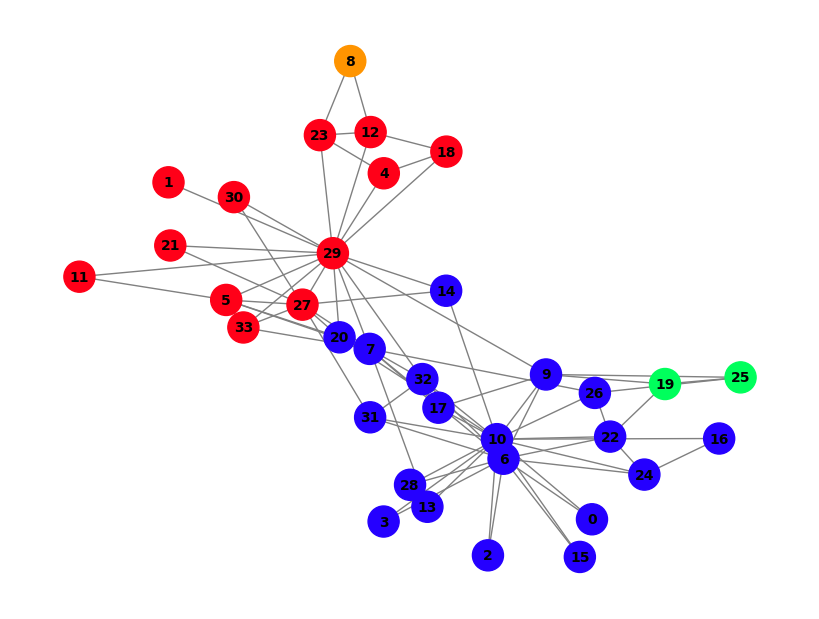

Rand index: 0.7254901960784313


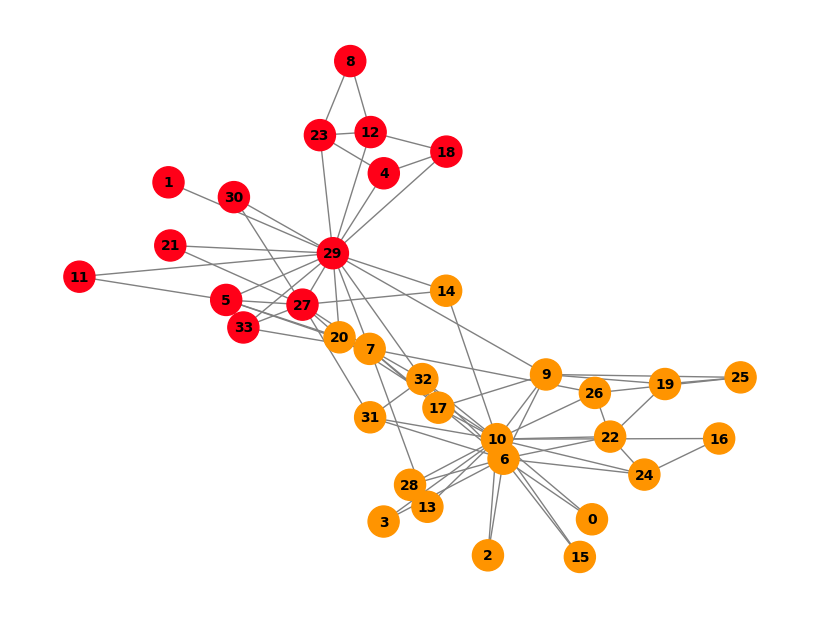

Rand index: 0.786096256684492


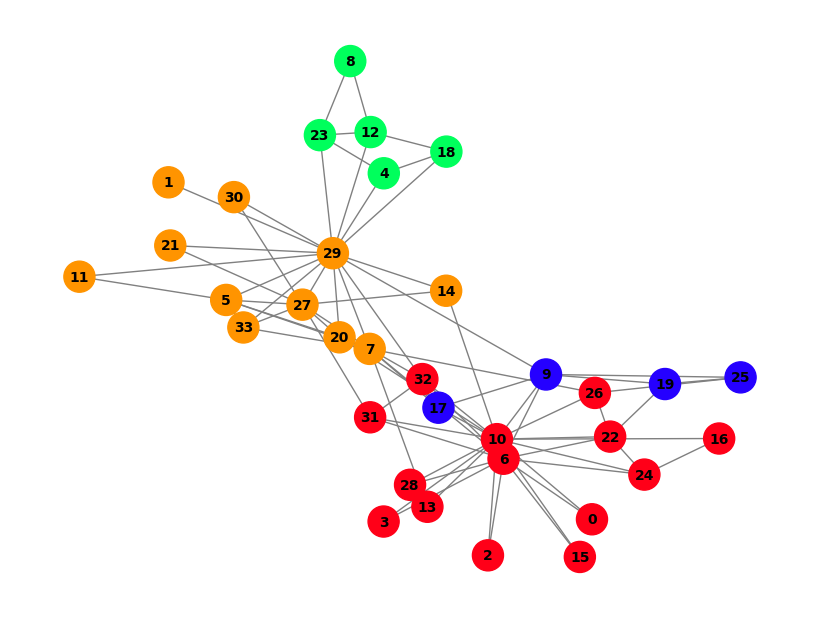

Rand index: 0.49376114081996436


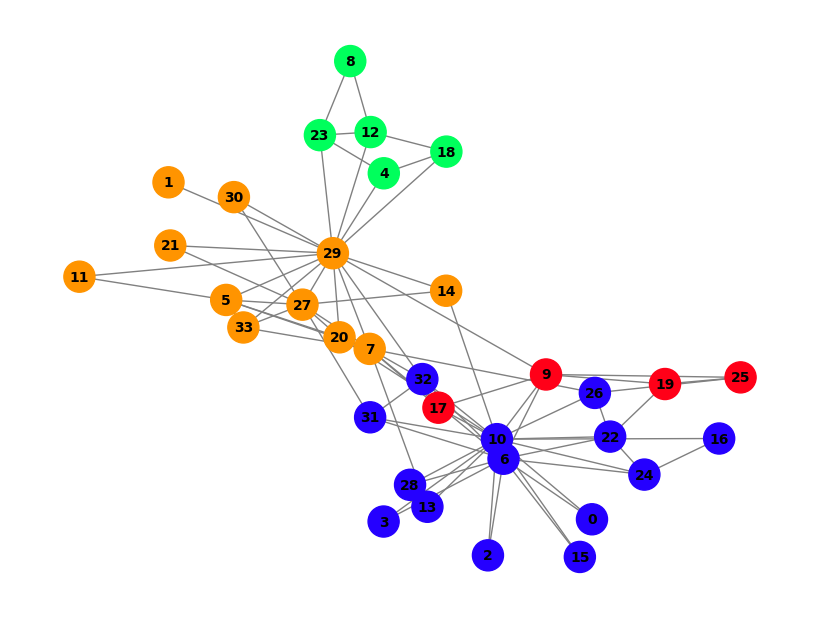

Rand index: 0.49376114081996436


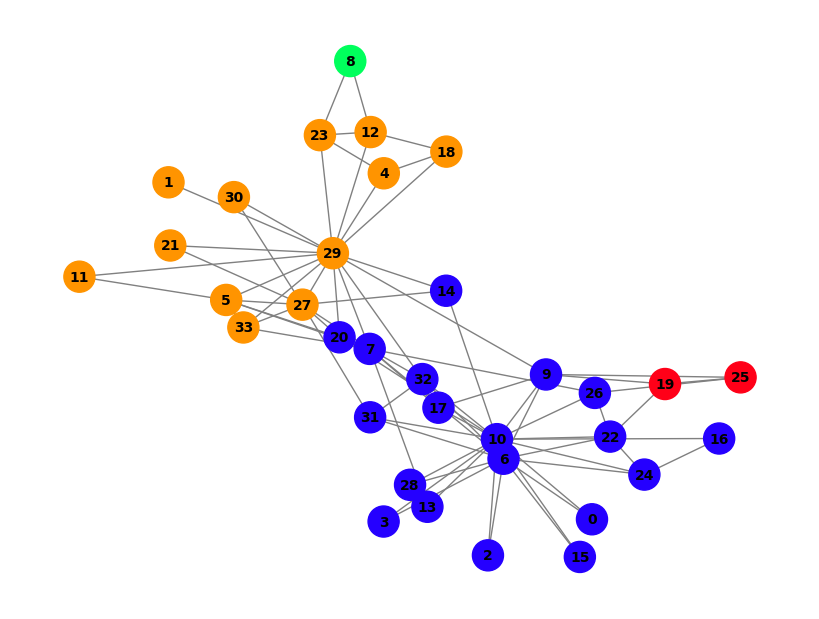

Rand index: 0.48663101604278075


In [8]:
import matplotlib.pyplot as plt

for clustering in [lp_a_e,lp_b_e,louvian_labels,leiden_labels,lp_c_e]:

    colors = plt.cm.hsv(np.linspace(0.1, 1, len(set(clustering.values()))))  # Generate distinct colors

    class_to_color = {cls: colors[i] for i, cls in enumerate(set(clustering.values()))}

    node_colors = [class_to_color[clustering[node]] for node in G.nodes()]
    
    # Draw the graph
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors, with_labels=True, 
            edge_color='gray', node_size=500, font_size=10, font_weight='bold')
    plt.show()

    print('Rand index:',rand_score(truth,list(clustering.values())))

# Jazz

Since there is no ground truth we need a different metric to compare the results

In [9]:
G = jazz.get_graph()
G = nx.relabel_nodes(G, {i : i-1 for i in range(len(G)+1)} )
G,_ = randomize_graph_node_labels(G,None)
#truth = list(map(lambda x: G.nodes[x]["club"], range(len(G))))
initial_clustering = {i : i for i in range(len(G))}
initial_clustering_k = {i : random.randint(0, 1) for i in range(len(G))}

agents = G.nodes()
G_F,G_E = create_graphs_hop_distance(G,0.2,0.2)

lp_a_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering,mode='E')
lp_b_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='E')

H = Modularity(1)
P = louvain(G, H, weight="weight")
louvian_labels = extract_labels_from_communities(P.communities)

Q = leiden(G, H, weight="weight")
leiden_labels = extract_labels_from_communities(Q.communities)

lp_c_e = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='E', max_coalitions=2)

#print('Rand index Local Heuristic:',rand_score(truth,list(lp_a_e.values())))
#print('Rand index Local Heuristic (k starting Coalitions):',rand_score(truth,list(lp_b_e.values())))
#print('Rand index Louvain:',rand_score(truth,list(louvian_labels.values())))
#print('Rand index Leiden:',rand_score(truth,list(leiden_labels.values())))
#print('Rand index Local Heuristic (starting from Leiden output):',rand_score(truth,list(lp_c_e.values())))
#check modularity, label propagation

# Cora

In [10]:
G = cora.get_graph()


G = nx.relabel_nodes(G, {list(G.nodes())[i] : i for i in range(len(G.nodes()))} )
G,_ = randomize_graph_node_labels(G,None)


truth = list(map(lambda x: G.nodes[x]['subject'], G.nodes()))

agents = G.nodes()

#initial_clustering = {i : i for i in range(len(G))}
initial_clustering_k = {i : i%7 for i in range(len(G))}

G_F,G_E = create_graphs_hop_distance(G,0.2,0.2)




start = time.perf_counter()
lp_b_e = locally_popular_clustering(agents, G_F, G_E, initial_clustering_k,mode='E')
end = time.perf_counter()
elapsed_lp_b_e = end - start


H = Modularity(1)
start = time.perf_counter()
P = louvain(G, H, weight="weight")
louvian_labels = extract_labels_from_communities(P.communities)
end = time.perf_counter()
elapsed_louvain = end - start

start = time.perf_counter()
Q = leiden(G, H, weight="weight")
leiden_labels = extract_labels_from_communities(Q.communities)
end = time.perf_counter()
elapsed_leiden = end - start



start = time.perf_counter()
lp_c_e = locally_popular_clustering(agents, G_F, G_E, leiden_labels,mode='E', max_coalitions=7)
end = time.perf_counter()
elapsed_lp_c_e = end - start




print('Rand index Local Heuristic (k starting Coalitions):',rand_score(truth,list(lp_b_e.values())))
print('in', elapsed_lp_b_e, 'seconds')
print('Rand index Louvain:',rand_score(truth,list(louvian_labels.values())))
print('in', elapsed_louvain, 'seconds')
print('Rand index Leiden:',rand_score(truth,list(leiden_labels.values())))
print('in', elapsed_leiden, 'seconds')
print('Rand index Local Heuristic (starting from Leiden output):',rand_score(truth,list(lp_c_e.values())))
print('in', elapsed_lp_c_e, 'seconds')

Rand index Local Heuristic (k starting Coalitions): 0.729156151320582
in 15.013122300006216 seconds
Rand index Louvain: 0.7960383905395444
in 1.7435923999873921 seconds
Rand index Leiden: 0.8125528268251412
in 2.940339499997208 seconds
Rand index Local Heuristic (starting from Leiden output): 0.8048480906496042
in 129.28519019999658 seconds
